In [100]:
# Import libraries
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns

import missingno as msno

# Libraries for NLP
import nltk
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
#from spacy.lang.en.stop_words.STOP_WORDS import STOP_WORDS
from nltk.corpus import stopwords 
#nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer, SnowballStemmer
#nltk.download('wordnet')
from nltk.tokenize import sent_tokenize
nltk.download('punkt')
import string
import gensim
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel

# Plotting
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to C:\Users\Bo-Yu
[nltk_data]     Chen\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [2]:
df_unhappy = pd.read_csv('hotel_reviews_not_happy.csv')
df_happy = pd.read_csv('hotel_reviews_happy.csv')
# Concatenate for total data
df_all_reviews = pd.concat([df_happy, df_unhappy], axis=0, ignore_index=True)
df_all_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38932 entries, 0 to 38931
Data columns (total 5 columns):
Unnamed: 0     38932 non-null int64
User_ID        38932 non-null object
Description    38932 non-null object
Is_Response    38932 non-null object
hotel_ID       38932 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 1.5+ MB


In [3]:
df_all_reviews[df_all_reviews.Is_Response=='happy'].count()

Unnamed: 0     26521
User_ID        26521
Description    26521
Is_Response    26521
hotel_ID       26521
dtype: int64

In [4]:
df_all_reviews.head()

,Unnamed: 0,User_ID,Description,Is_Response,hotel_ID
0,3,id10329,Stayed here with husband and sons on the way t...,happy,6.0
1,5,id10331,We had - rooms. One was very nice and clearly ...,happy,6.0
2,7,id10333,My wife & I stayed in this glorious city a whi...,happy,4.0
3,8,id10334,My boyfriend and I stayed at the Fairmont on a...,happy,4.0
4,10,id10336,"Steps off Times Square, nice rooms, stayed - n...",happy,3.0


Check missing data

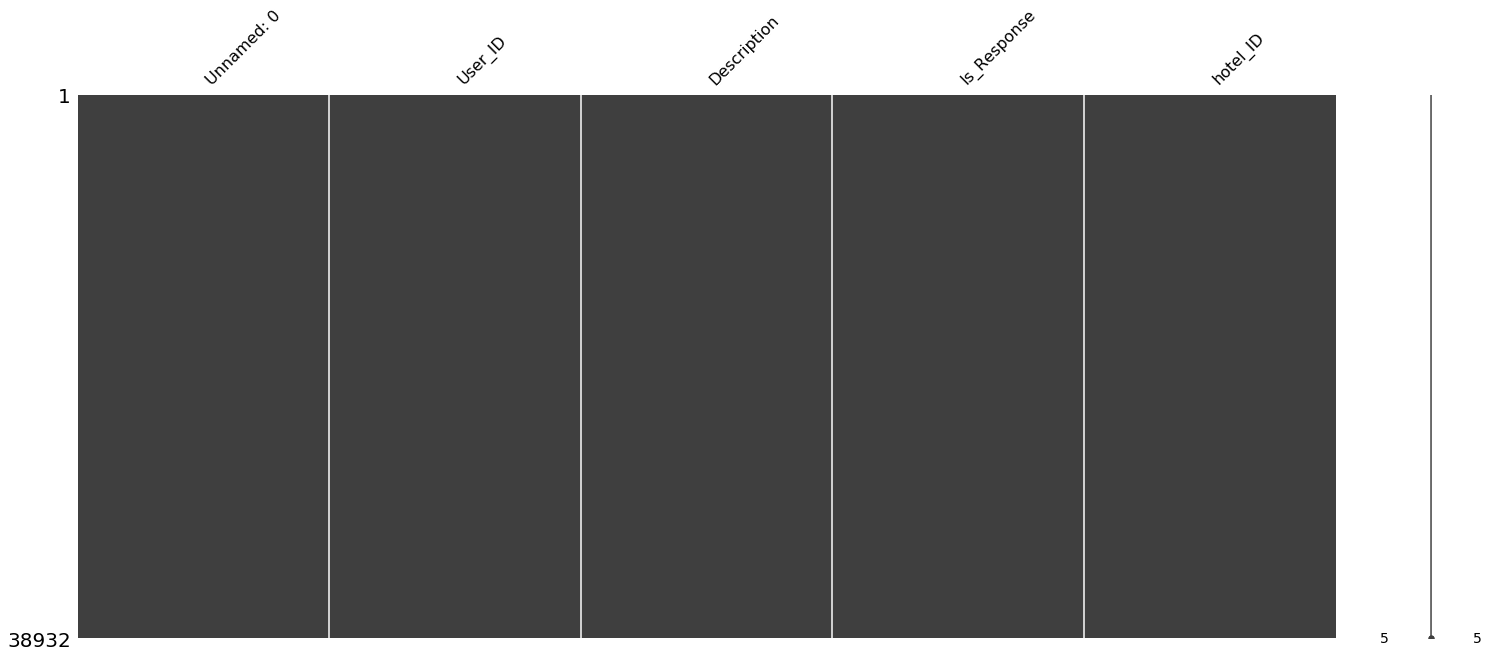

In [5]:
msno.matrix(df_all_reviews)

Good! There is no missing data.

In [6]:
df_all_reviews.Is_Response = df_all_reviews.Is_Response.apply(lambda x: 1 if x == 'happy' else 0)

In [7]:
sum(df_all_reviews.Is_Response)

26521

Text(0.5,1,'Total Reviews')

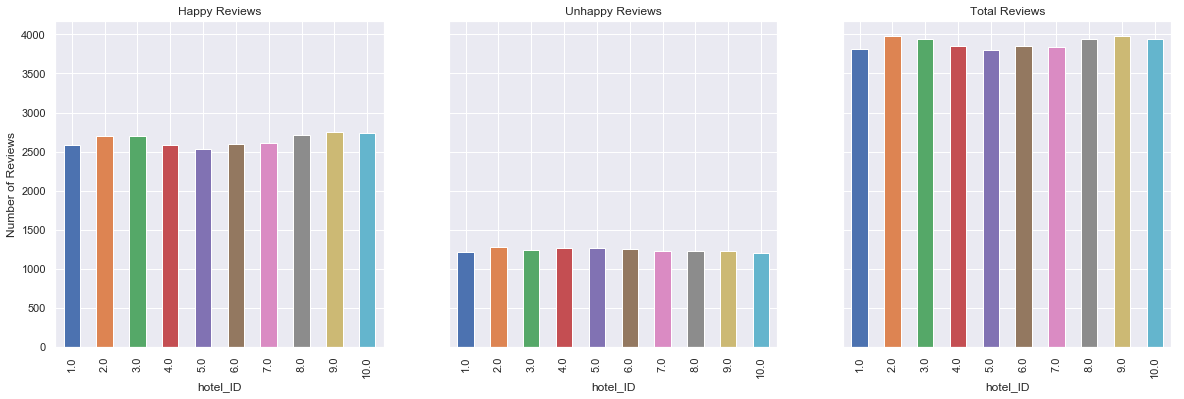

In [8]:
# Find number of happy reviews for each of the ten hotels
df_num_happy_reviews_per_hotel = pd.pivot_table(df_all_reviews[df_all_reviews.Is_Response==1], index='hotel_ID', values='User_ID', aggfunc='count')
df_num_happy_reviews_per_hotel = df_num_happy_reviews_per_hotel.reset_index()
# Find number of not happy reviews for each of the ten hotels
df_num_unhappy_reviews_per_hotel = pd.pivot_table(df_all_reviews[df_all_reviews.Is_Response==0], index='hotel_ID', values='User_ID', aggfunc='count')
df_num_unhappy_reviews_per_hotel = df_num_unhappy_reviews_per_hotel.reset_index()
df_num_reviews_per_hotel = pd.pivot_table(df_all_reviews, index='hotel_ID', values='User_ID', aggfunc='count')
df_num_reviews_per_hotel = df_num_reviews_per_hotel.reset_index()

sns.set()
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6), sharey=True)
df_num_happy_reviews_per_hotel.plot(kind='bar', x='hotel_ID', y='User_ID', legend=False, ax=ax1)
plt.xticks(rotation=0)
ax1.set_title('Happy Reviews')
ax1.set_ylabel('Number of Reviews')
df_num_unhappy_reviews_per_hotel.plot(kind='bar', x='hotel_ID', y='User_ID', legend=False, ax=ax2)
ax2.set_title('Unhappy Reviews')
plt.xticks(rotation=90)
df_num_reviews_per_hotel.plot(kind='bar', x='hotel_ID', y='User_ID', legend=False, ax=ax3)
ax3.set_title('Total Reviews')


Each hotel received similar amount of reviews. Therefore, it is good to train NLP model, since the reviews from single hotel would not dominate.

In [9]:
print('Total reviews compiled = %d' % len(df_all_reviews))
print('Number of unique user IDs = %d' % len(np.unique(df_all_reviews['User_ID'])))

Total reviews compiled = 38932
Number of unique user IDs = 38932


No duplicated data.
## Data Pre-Process for NLP
Tokenization, removing stop words and punctuation, and lemmatization
Create bi-gram and tri-gram
Prepare dictionary for training topic model

In [10]:
#Tokenization
all_text_list = df_all_reviews['Description'].tolist()
# Remove the stop words, puncutation, stemming and lemmatize
# The stop words are from the combination of nltk and spaCy stop word sets
stop = stopwords.words('english')
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
stop.extend(spacy_stopwords)
stop = list(dict.fromkeys(stop))
stop.remove('not') #'not' is meaningful in some circumstances, especially in customers’ reviews, so remove it from stop word list

exclude = set(string.punctuation) 
lemma = WordNetLemmatizer()
def clean(doc):
    # Remove stop words
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    # Remove punctuation
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    # lemmatize the corpus
    lemmatized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return lemmatized

text_all_clean = [clean(text).split() for text in all_text_list]

In [12]:
stemmer = SnowballStemmer('english')
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    # The stop words are from the combination of nltk and spaCy stop word sets
    stop = stopwords.words('english')
    spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
    stop.extend(spacy_stopwords)
    stop = list(dict.fromkeys(stop))
    #'not' is meaningful in some circumstances, especially in customers’ reviews, so remove it from stop word list
    stop.remove('not') 
    
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in stop and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [13]:
text_all_clean = df_all_reviews['Description'].map(preprocess)

In [11]:
print(text_all_clean[1])

['room', 'nice', 'clearly', 'updated', 'recently', 'other', 'clean', 'bed', 'comfy', 'needed', 'updating', 'carpet', 'old', 'wrinkled', 'example', 'great', 'location', 'visiting', 'inner', 'harbor', 'getting', 'fell', 'point', 'oriole', 'game', 'etc', 'supershuttle', 'bwi', 'worked', 'great', 'way', 'tv', 'remote', 'room', 'terrible', 'watch', 'tv', 'not', 'big', 'deal', 'wireless', 'sketchy', 'th', 'th', 'floor', 'again', 'need', 'vacation', 'matter', 'breakfast', 'good', 'morning', 'stay', 'town']


In [14]:
# Create bi-gram
bigram = gensim.models.Phrases(text_all_clean, min_count=5, threshold=30)
bigram_mod = gensim.models.phrases.Phraser(bigram)
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [15]:
# Create tri-gram
trigram = gensim.models.Phrases(bigram[text_all_clean], threshold=30) 
trigram_mod = gensim.models.phrases.Phraser(trigram)
def make_trigrams(texts):
    return [trigram_mod[doc] for doc in texts]

In [16]:
text_tri = make_trigrams(text_all_clean)

In [17]:
dictionary = gensim.corpora.Dictionary(text_tri)

In [18]:
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in text_all_clean]

In [24]:
len(bow_corpus)

38932

# Topic Modeling Using Latent Dirichlet Allocation (LDA)

In [27]:
import time
start_time = time.time()
lda_model=gensim.models.ldamodel.LdaModel(bow_corpus, 
                                                 num_topics=10, 
                                                 id2word = dictionary, 
                                                 passes=200, 
                                                 random_state=100,
                                                 alpha='auto')
print("--- %s seconds ---" % (time.time() - start_time))

--- 1868.6099841594696 seconds ---


In [23]:
print(lda_model.print_topics())

[(0, '0.008*"tell" + 0.007*"expect" + 0.005*"discount" + 0.004*"cool" + 0.004*"say" + 0.004*"provid" + 0.003*"recent" + 0.003*"check" + 0.003*"temperatur" + 0.003*"ladi"'), (1, '0.005*"closet" + 0.005*"affinia" + 0.005*"seattl" + 0.005*"hour" + 0.005*"later" + 0.005*"problem" + 0.004*"iron" + 0.004*"airport" + 0.004*"flight" + 0.004*"plenti"'), (2, '0.002*"termin" + 0.002*"salmon" + 0.002*"salad" + 0.002*"bridg" + 0.002*"expect" + 0.002*"odd" + 0.000*"road" + 0.000*"expens" + 0.000*"decor" + 0.000*"maci"'), (3, '0.007*"tour" + 0.006*"elyse" + 0.005*"fame" + 0.005*"hour" + 0.004*"mall" + 0.004*"pizza" + 0.004*"wharf" + 0.004*"receiv" + 0.004*"pay" + 0.003*"request"'), (4, '0.000*"bedbug" + 0.000*"broadway_theatr" + 0.000*"confort" + 0.000*"newli" + 0.000*"sympathet" + 0.000*"unbear" + 0.000*"draft" + 0.000*"dial" + 0.000*"rockefel_centr" + 0.000*"appli"'), (5, '0.006*"fairmont" + 0.004*"confer" + 0.004*"recent" + 0.003*"updat" + 0.003*"boyfriend" + 0.003*"cake" + 0.003*"luxuri" + 0.003*

In [58]:
# Find the best number of topics by the coherence measurement
def best_topic_num(corpus, text, num_list):
    coher = []
    BestModel = 0
    coher_curr = 0
    num_best = 0
    for num_topics in num_list:
        print(num_topics)
        LdaModel_test = LdaModel(corpus=corpus,
                        id2word=dictionary,
                        iterations=40,
                        num_topics=num_topics,
                        random_state=100,
                        alpha='auto',
                        passes=5)
        cm = CoherenceModel(model=LdaModel_test,
                        texts=text,
                        dictionary=dictionary,
                        coherence='c_v')
        coher.append(cm.get_coherence())
        if coher[-1] > coher_curr:
            BestModel = LdaModel_test
            num_best = num_topics
            coher_curr = coher[-1]
    return BestModel, num_best, coher

In [59]:
num_topics_test = [5, 10, 15, 20, 30]
Lda_best, num_topic_best, coherence = best_topic_num(bow_corpus, text_tri, num_topics_test)

5
10
15
20
30


Text(0.5,0,'# of topics')

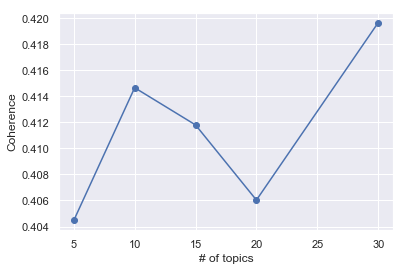

In [63]:
plt.plot(num_topics_test, coherence, 'o-')
plt.ylabel('Coherence')
plt.xlabel('# of topics')

According to coherence, 30 topics is the best. However, the topics should be more concentrated in real case. Therefore, I choose to calculate the coherence with topic numbers around 10.

In [64]:
num_topics_test = [8, 9, 10, 11, 12]
Lda_best, num_topic_best, coherence = best_topic_num(bow_corpus, text_tri, num_topics_test)

8
9
10
11
12


Text(0.5,0,'# of topics')

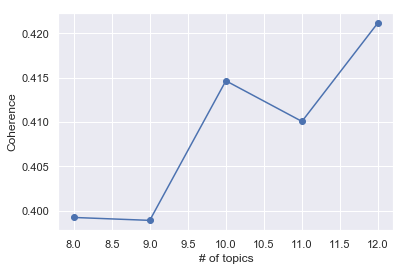

In [65]:
plt.plot(num_topics_test, coherence, 'o-')
plt.ylabel('Coherence')
plt.xlabel('# of topics')

In [69]:
num_topics_test = [12, 13, 14]
Lda_best, num_topic_best, coherence = best_topic_num(bow_corpus, text_tri, num_topics_test)

12
13
14


Text(0.5,0,'# of topics')

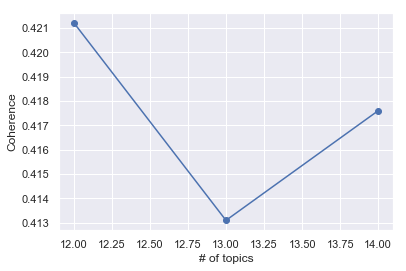

In [70]:
plt.plot(num_topics_test, coherence, 'o-')
plt.ylabel('Coherence')
plt.xlabel('# of topics')

In [72]:
num_topics_test = [12]
Lda_best, num_topic_best, coherence = best_topic_num(bow_corpus, text_tri, num_topics_test)

12


In [73]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(Lda_best, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.117743  0.099476       1        1  21.468180
11     0.179641  0.051363       2        1  11.220573
3     -0.067612 -0.063936       3        1  10.026614
8      0.054893 -0.106437       4        1   9.061790
6      0.085418 -0.171135       5        1   8.073009
2     -0.298348 -0.053780       6        1   6.641768
10    -0.023478  0.104682       7        1   6.030398
9      0.016301 -0.107803       8        1   5.932990
4      0.072953  0.243263       9        1   5.868688
5      0.065560  0.160493      10        1   5.614032
7     -0.162424 -0.025068      11        1   5.409402
0      0.194841 -0.131118      12        1   4.652555, topic_info=     Category          Freq        Term         Total  loglift  logprob
term                                                                   
100   Default  26831.000000       staff  26831.000000  30.0000  30.0000
27    Default  14698.000000        walk  14698.000000  29.0000  29.0000
29    Default  13960.000000   breakfast  13960.000000  28.0000  28.0000
40    Default  25239.000000       locat  25239.000000  27.0000  27.0000
12    Default  21777.000000       great  21777.000000  26.0000  26.0000
419   Default  13170.000000        park  13170.000000  25.0000  25.0000
313   Default  13940.000000      friend  13940.000000  24.0000  24.0000
75    Default  12691.000000        help  12691.000000  23.0000  23.0000
157   Default   8229.000000        free   8229.000000  22.0000  22.0000
44    Default  17122.000000        nice  17122.000000  21.0000  21.0000
22    Default  16163.000000      servic  16163.000000  20.0000  20.0000
439   Default  10149.000000    bathroom  10149.000000  19.0000  19.0000
31    Default  19353.000000       clean  19353.000000  18.0000  18.0000
95    Default  10826.000000     restaur  10826.000000  17.0000  17.0000
691   Default   6985.000000        tell   6985.000000  16.0000  16.0000
234   Default   7177.000000        pool   7177.000000  15.0000  15.0000
38    Default  19469.000000        good  19469.000000  14.0000  14.0000
172   Default   3405.000000     airport   3405.000000  13.0000  13.0000
444   Default   3855.000000      center   3855.000000  12.0000  12.0000
2096  Default   4811.000000       squar   4811.000000  11.0000  11.0000
285   Default   5266.000000       coffe   5266.000000  10.0000  10.0000
166   Default   7115.000000      street   7115.000000   9.0000   9.0000
380   Default  19152.000000        time  19152.000000   8.0000   8.0000
423   Default   5097.000000      shower   5097.000000   7.0000   7.0000
742   Default   3007.000000        wall   3007.000000   6.0000   6.0000
223   Default   4315.000000    internet   4315.000000   5.0000   5.0000
754   Default   6376.000000        food   6376.000000   4.0000   4.0000
397   Default   5447.000000       block   5447.000000   3.0000   3.0000
145   Default   4073.000000    downtown   4073.000000   2.0000   2.0000
393   Default   5299.000000        suit   5299.000000   1.0000   1.0000
...       ...           ...         ...           ...      ...      ...
2632  Topic12    655.325745        game    821.078369   2.8423  -5.0267
1645  Topic12    148.450562      campus    158.988937   2.9992  -6.5116
227   Topic12    710.338196        mall   1016.917969   2.7090  -4.9461
145   Topic12   2256.183350    downtown   4073.461914   2.4769  -3.7904
2693  Topic12   1642.874756     distanc   3016.336670   2.4602  -4.1076
1119  Topic12    703.410217      market   1205.218994   2.5293  -4.9559
27    Topic12   4595.070801        walk  14698.177734   1.9050  -3.0791
1257  Topic12    729.638611      attend   1491.219482   2.3530  -4.9193
95    Topic12   2777.405273     restaur  10826.366211   1.7073  -3.5826
708   Topic12    374.756226  washington    593.989258   2.6072  -5.5856
239   Topic12   1377.633789        shop   4497.385254   1.8846  -4.2837
1330  Topic12    301.904968      

In [79]:
pprint.pprint(Lda_best.print_topics(-1))

[(0,
  '0.046*"walk" + 0.029*"center" + 0.028*"restaur" + 0.027*"locat" + '
  '0.023*"downtown" + 0.021*"great" + 0.020*"convent" + 0.017*"confer" + '
  '0.016*"distanc" + 0.014*"shop"'),
 (1,
  '0.020*"check" + 0.018*"night" + 0.015*"tell" + 0.015*"desk" + 0.014*"go" + '
  '0.013*"time" + 0.011*"say" + 0.010*"book" + 0.010*"leav" + 0.010*"ask"'),
 (2,
  '0.024*"bathroom" + 0.021*"wall" + 0.019*"door" + 0.018*"floor" + '
  '0.018*"shower" + 0.017*"window" + 0.014*"carpet" + 0.012*"dirti" + '
  '0.012*"open" + 0.011*"light"'),
 (3,
  '0.043*"nice" + 0.025*"good" + 0.023*"like" + 0.021*"night" + '
  '0.020*"bathroom" + 0.019*"clean" + 0.018*"small" + 0.016*"great" + '
  '0.015*"locat" + 0.015*"bed"'),
 (4,
  '0.027*"pool" + 0.019*"servic" + 0.019*"view" + 0.016*"beauti" + '
  '0.014*"love" + 0.012*"kid" + 0.012*"resort" + 0.011*"like" + 0.010*"time" + '
  '0.010*"experi"'),
 (5,
  '0.027*"servic" + 0.026*"food" + 0.023*"restaur" + 0.020*"breakfast" + '
  '0.016*"order" + 0.016*"dinner" +

In [75]:
Lda_best.save('Lda_best')

After reading the keywords from each topic, I am able to interpret and label these topics.

In [82]:
topics_dict = {
  '0' : 'Location',
  '1' : 'Front Desk',
  '2' : 'Bathroom',
  '3' : 'Cleanliness',
  '4' : 'Amenity',
  '5' : 'Food',
  '6' : 'Neighborhood Environment',
  '7' : 'Room Facility',
  '8' : 'New York Specific Topic',
  '9' : 'Service',
  '10': 'Value of Money',
  '11': 'Staff'}

Identify the topics for all reviews.

In [ ]:
from nltk.tokenize import sent_tokenize

def sentence_topic_class_list(sent_list):
    index_list = []
    for sent in sent_list:
        bow_vector = dictionary.doc2bow(preprocess(sent))
        index, score = sorted(lda_model[bow_vector], key=lambda tup: -1*tup[1])[0]
        index_list.append(index)
    return index_list

all_sent_topic = happy_hotel['Description'].map(sent_tokenize).map(sentence_topic_class_list)

In [154]:
df_bow_corpus = pd.DataFrame({'col':bow_corpus})
df_topic = df_bow_corpus.apply(lambda x: sorted(Lda_best[x][0], key=lambda tup: -1*tup[1])[0][0], axis=1)

In [159]:
df_all_reviews['Topic'] = df_topic

# What the Customers talked about

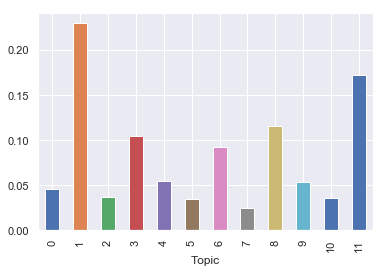

In [171]:
(df_all_reviews.groupby('Topic').count()['User_ID']/len(df_all_reviews)).plot('bar')

In [110]:

df_all_reviews['Description'][2]

"My wife & I stayed in this glorious city a while back. SF is expensive, but we found this little hotel in a super location for a very reasonable price. By no means is it a --star hotel, but the room was clean, nice & well-appointed with quaint charm, despite being a bit small. Regardless of that, the staff was very helpful. I particularly enjoyed the wine-tasting evenings & the helpful, polite front desk.\r\nOverall, I'd recommend this place for singles or couples, but for children present, you probably need a bit bigger room. For the location & proximity to everything (including a marvelous little Mexican restaurant around the corner), you can't beat this place for the price. SF is a magical city with plenty of things to do, so I'd recommend just crashing here & seeing the wonderful surroundings more than hanging out in a room all day.\r\nWould recommend again for a getaway for -, but not for families because of the room size."

In [117]:
sorted(Lda_best[bow_corpus[0:2]], key=lambda tup: -1*tup[1])

(0, 0.22938798)

In [119]:
bow_corpus[0:2]

[[(1, 1), (2, 1), (3, 2), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (20, 1), (21, 2), (22, 2), (23, 1), (24, 1), (25, 1), (26, 3), (27, 1), (28, 1), (906, 1), (1250, 1), (2389, 2)], [(10, 1), (12, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (37, 1), (38, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 1), (346, 1), (362, 1), (989, 1), (2632, 1), (4473, 1), (4747, 1)]]

In [137]:
Lda_best[df_bow_corpus.iloc[33248]][0]

[(1, 0.95986325)]

In [133]:
df_topic.head()

0     (0, 0.2984629)
1    (0, 0.20496938)
2    (0, 0.34540635)
3    (0, 0.18405011)
4    (0, 0.23555532)
dtype: object

In [134]:
df_bow_corpus.iloc[33248]

col    [(27, 1), (37, 1), (56, 1), (66, 4), (71, 1), ...
Name: 33248, dtype: object

In [153]:
sorted(Lda_best[df_bow_corpus.iloc[2]][0], key=lambda tup: -1*tup[1])[0][0]

11

In [142]:
Lda_best[df_bow_corpus.iloc[33248]][0]

[(1, 0.9598982)]

In [150]:
Lda_best[df_bow_corpus.iloc[2]][0]

[(1, 0.0192759), (3, 0.19477752), (4, 0.100714915), (5, 0.089999914), (6, 0.09060947), (8, 0.0746858), (10, 0.06555163), (11, 0.35419995)]

In [158]:
df_topic[0]

4